In [1]:
import os
import pandas as pd
import pickle 
import itertools
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
w2v_filename = '/data/GoogleNews-vectors-negative300.bin'
if not os.path.exists(w2v_filename):
    w2v_filename = False 
import gensim
duplicate_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_filename, binary=True)
duplicate_model.init_sims(replace=True)

In [2]:
class alter_ideas(object):
    def __init__(self,
                ideawise_gender_dict,
                ideawise_race_dict, 
                alter_demography_collection,
                alter_annotation_dict,
                ID_to_content_bagofwords_mapping_alter,
                process = True):
        
        self.ideawise_gender_dict = ideawise_gender_dict
        self.ideawise_race_dict = ideawise_race_dict 
        self.alter_demography_collection = alter_demography_collection
        self.alter_annotation_dict = alter_annotation_dict
        self.ID_to_content_bagofwords_mapping_alter = ID_to_content_bagofwords_mapping_alter

        if process:
            self.plot_within_vs_between("gender")
            self.plot_within_vs_between("race")
     
    def mean_confidence_interval(self, data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h
    
    def full_t_test(self, x1, x2, bonferroni = 1):
        N1 = len(x1)
        N2 = len(x2)
        df = N1+N2-2
        m1 = np.mean(x1)
        m2 = np.mean(x2)
        std1 = np.std(x1)
        std2 = np.std(x2)
        t, p = stats.ttest_ind(x1,x2)
        print('$m_1='+str(round(m1,2))+'$, $m_2='+str(round(m2,2))+'$, $t('+str(df)+')='+str(round(t,3))+'$, $p='+str(p)+ '$,')
        p_new = p * bonferroni
        print('Bonferroni-corrected (uncorrected $p$-val $\\times '+str(bonferroni)+'$) p='+str(p_new))
        from scipy.stats import t
        std_N1N2 = sqrt( ((N1 - 1)*(std1)**2 + (N2 - 1)*(std2)**2) / df) 

        diff_mean = m1 - m2
        MoE = t.ppf(0.975, df) * std_N1N2 * sqrt(1/N1 + 1/N2)
        ind_t_test = stats.ttest_ind(x1,x2)
        print ('$95\%$ C.I. for $m_1-m_2=[{:3.3f}, {:3.3f}]$'.format(diff_mean - MoE, diff_mean + MoE))

    
    def document_vector(self, doc):
        # remove out-of-vocabulary words
        doc = [word for word in doc if word in duplicate_model.vocab]
        return np.mean(duplicate_model[doc], axis=0).reshape(1, -1)

    def compute_div_cosine_distance_alter(self, t1,t2,round_id):
        doc1 = list(self.ID_to_content_bagofwords_mapping_alter[round_id][t1])
        doc2 = list(self.ID_to_content_bagofwords_mapping_alter[round_id][t2])
        if (len(doc1)>=1 and len(doc2)>=1): 
            docvec1 = self.document_vector(doc1)
            docvec2 = self.document_vector(doc2)
            return cosine_similarity(docvec1,docvec2)[0][0]
        else:
            return None
    
    def duplicate_alters_exist(self, t1,t2,round_,cond="male"): 
        t1_set = set()
        t2_set = set()
        
        for alter_id in self.alter_demography_collection[cond]:
            idea_list = self.alter_annotation_dict[alter_id][round_][1] 
            if t1 in idea_list:
                t1_set.add(alter_id)
                if len(t1_set)>1:
                    return True
            if t2 in idea_list:
                t2_set.add(alter_id)
                if len(t2_set)>1:
                    return True

            union_set = t1_set.union(t2_set)
            if len(t1_set)>0 and len(t2_set)>0 and len(union_set)<2:
                return False
            else:
                return True    
    
    def generate_within_between_gender_lists(self):
        alter_corrected_male_IDs_dict = {1:[],2:[],3:[],4:[],5:[]}
        alter_corrected_female_IDs_dict = {1:[],2:[],3:[],4:[],5:[]}
        alter_corrected_both_IDs_dict = {1:[],2:[],3:[],4:[],5:[]}

        for roundID,roundDict in self.ideawise_gender_dict.items():
            for ideaID, genderSet in roundDict.items():
                if 'Non-Male' in genderSet and 'Male' in genderSet:
                    alter_corrected_both_IDs_dict[roundID].append(ideaID)
                else:
                    if 'Non-Male' in genderSet:
                        alter_corrected_female_IDs_dict[roundID].append(ideaID)
                    if 'Male' in genderSet:
                        alter_corrected_male_IDs_dict[roundID].append(ideaID)
        missed=0
        within_group_corrected_distances_gender_cosine = []
        between_group_corrected_distances_gender_cosine = []
        for roundID in range(1,6):

            for t1,t2 in list(itertools.combinations(alter_corrected_male_IDs_dict[roundID], 2)):
                if not self.duplicate_alters_exist(t1,t2,roundID,cond="male"): 
                    continue
                k = self.compute_div_cosine_distance_alter(t1,t2,roundID)
                if k:
                    within_group_corrected_distances_gender_cosine.append(k)
                else:
                    missed+=1

            for t1,t2 in list(itertools.combinations(alter_corrected_female_IDs_dict[roundID], 2)):
                if not self.duplicate_alters_exist(t1,t2,roundID,cond="non-male"): 
                    continue
                k = self.compute_div_cosine_distance_alter(t1,t2,roundID)
                if k:
                    within_group_corrected_distances_gender_cosine.append(k)
                else:
                    missed+=1

            for m in alter_corrected_male_IDs_dict[roundID]:
                for f in alter_corrected_female_IDs_dict[roundID]:
                    k= self.compute_div_cosine_distance_alter(m,f,roundID)
                    if k:
                        between_group_corrected_distances_gender_cosine.append(k)
                    else:
                        missed+=1

        self.full_t_test(within_group_corrected_distances_gender_cosine,between_group_corrected_distances_gender_cosine)
        return within_group_corrected_distances_gender_cosine,between_group_corrected_distances_gender_cosine
    
    def generate_within_between_race_lists(self):
        alter_corrected_white_IDs_dict = {1:[],2:[],3:[],4:[],5:[]}
        alter_corrected_non_white_IDs_dict = {1:[],2:[],3:[],4:[],5:[]}
        alter_corrected_both_IDs_dict = {1:[],2:[],3:[],4:[],5:[]}

        for roundID,roundDict in self.ideawise_race_dict.items():
            for ideaID, ethnicitySet in roundDict.items():
                if 'White' in ethnicitySet and 'Non-White' in ethnicitySet:
                    alter_corrected_both_IDs_dict[roundID].append(ideaID)
                else:
                    if 'White' in ethnicitySet:
                        alter_corrected_white_IDs_dict[roundID].append(ideaID)
                    if 'Non-White' in ethnicitySet:
                        alter_corrected_non_white_IDs_dict[roundID].append(ideaID)

        within_group_corrected_distances_ethnicity_cosine = []
        between_group_corrected_distances_ethnicity_cosine = []
        for roundID in range(1,6):
            for t1,t2 in list(itertools.combinations(alter_corrected_white_IDs_dict[roundID], 2)):
                if not self.duplicate_alters_exist(t1,t2,roundID,cond="white"): 
                    continue
                k = self.compute_div_cosine_distance_alter(t1,t2,roundID)
                if k:
                    within_group_corrected_distances_ethnicity_cosine.append(k)
            for t1,t2 in list(itertools.combinations(alter_corrected_non_white_IDs_dict[roundID], 2)):
                if not self.duplicate_alters_exist(t1,t2,roundID,cond="non-white"): 
                    continue
                k = self.compute_div_cosine_distance_alter(t1,t2,roundID)
                if k:
                    within_group_corrected_distances_ethnicity_cosine.append(k)
            for m in alter_corrected_white_IDs_dict[roundID]:
                for f in alter_corrected_non_white_IDs_dict[roundID]:
                    k = self.compute_div_cosine_distance_alter(m,f,roundID)
                    if k:
                        between_group_corrected_distances_ethnicity_cosine.append(k)

        self.full_t_test(within_group_corrected_distances_ethnicity_cosine,between_group_corrected_distances_ethnicity_cosine)
        return within_group_corrected_distances_ethnicity_cosine, between_group_corrected_distances_ethnicity_cosine
        
    def plot_within_vs_between(self, cond = "gender"):
        means=[]
        conf =[]
        print("Analyzing "+str(cond)+"-based homogeneity of ideas")
        if cond=="gender":
            within_group_list, between_group_list = self.generate_within_between_gender_lists()
        elif cond == "race":
            within_group_list, between_group_list = self.generate_within_between_race_lists()
        
        means.append(self.mean_confidence_interval(within_group_list)[0])
        conf.append([self.mean_confidence_interval(within_group_list)[1],\
                     self.mean_confidence_interval(within_group_list)[2]])

        means.append(self.mean_confidence_interval(between_group_list)[0])
        conf.append([self.mean_confidence_interval(between_group_list)[1],\
                     self.mean_confidence_interval(between_group_list)[2]])

        means=np.array(means)
        conf=np.array(conf)
        yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

        plt.rc('figure', figsize = (8,6))
        plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
        my_xticks = ['Idea-pairs from alters of \nthe same '+str(cond),'Idea-pairs from alters of \ndifferent '+str(cond)]
        plt.xticks([0,1], my_xticks)
        plt.ylim([0.23,0.33])
        plt.ylabel('Pairwise Cosine Similarity')
        plt.title('Within vs between -- '+str(cond))
        plt.show()

In [3]:
filehandler = open('data/homogeneity.obj', 'rb') 
data_obj = pickle.load(filehandler)

Analyzing gender-based homogeneity of ideas
$m_1=0.31$, $m_2=0.27$, $t(4633)=11.659$, $p=5.589456529453629e-31$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=5.589456529453629e-31
$95\%$ C.I. for $m_1-m_2=[0.035, 0.048]$


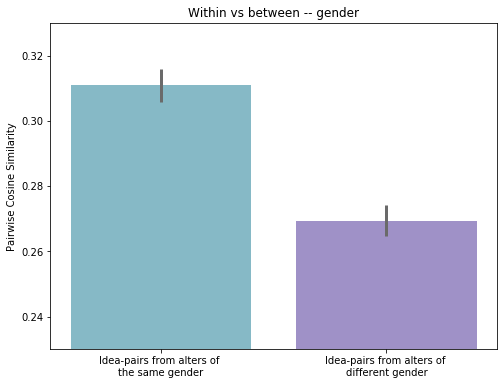

In [4]:
data_obj.plot_within_vs_between("gender")

Analyzing race-based homogeneity of ideas
$m_1=0.3$, $m_2=0.28$, $t(4870)=5.729$, $p=1.0739378548195724e-08$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=1.0739378548195724e-08
$95\%$ C.I. for $m_1-m_2=[0.013, 0.027]$


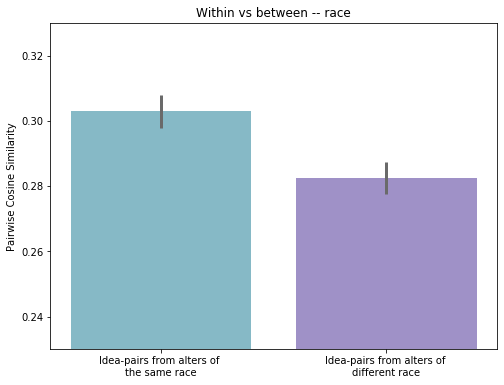

In [5]:
data_obj.plot_within_vs_between("race")